## Importing Libraries

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import pickle

import multiprocessing

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
path = 'drive/MyDrive/ADM/movielens/'

##Utility Methods

In [ ]:
# returns a list of indexs from dataset, which will be used for validation data.

def get_validation_set(n, cv_idx=0, val_pct=0.2, seed=42):
    np.random.seed(seed)
    n_val = int(val_pct * n)
    idx_start = cv_idx * n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start + n_val]

In [ ]:
# return two arrays as tupple, where first array is the array of elements selected based on
# passed indexes and second array is array of rest of the elements

def split_data(idxs, *a):
    mask = np.zeros(len(a[0]), dtype=bool)
    mask[np.array(idxs)] = True
    return [(o[mask], o[~mask]) for o in a]


In [ ]:
# class for formating dataset to feed into Auto Encoder network

class DataWraper(Dataset):
    def __init__(self, x_train):
        self.x = x_train

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x, y = self.x.iloc[idx].values, self.x.iloc[idx].values
        x = torch.from_numpy(x).type(torch.FloatTensor)
        y = torch.from_numpy(y).type(torch.FloatTensor)
        return {'input': x, 'target': y}

## Defining Model

In [ ]:
# Encoder class

class Encoder(nn.Module):
    def __init__(self, input_size, intermediate_size, encoding_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, encoding_size),
            nn.BatchNorm1d(encoding_size),
            nn.ReLU(True),
            nn.Dropout(0.2))

    def forward(self, x):
        x = self.encoder(x)
        return x

# Decoder class

class Decoder(nn.Module):
    def __init__(self, output_size, intermediate_size, encoding_size):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, intermediate_size),
            nn.BatchNorm1d(intermediate_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(intermediate_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        return x

In [ ]:
# Combined AutoEncoder class

class AutoEncoder(object):

    def __init__(self, data, validation_perc=0.2, lr=0.001,
                 intermediate_size=1000, encoded_size=100):

        self.data = data
        self.val_idxs = get_validation_set(n=data.shape[0], val_pct=validation_perc)
        [(self.val, self.train)] = split_data(self.val_idxs, data)
        self.dataset = DataWraper(self.train)
        self.dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True, num_workers=multiprocessing.cpu_count())
        self.val = torch.from_numpy(self.val.values).type(torch.FloatTensor).cuda()

        size = data.shape[1]
        self.encoder = Encoder(size, intermediate_size, encoded_size).cuda()
        self.decoder = Decoder(size, intermediate_size, encoded_size).cuda()

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=lr, weight_decay=1e-8)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=lr, weight_decay=1e-8)

        self.criterion = nn.MSELoss(reduction='elementwise_mean')

        self.train_losses = []
        self.val_losses = []

    def train_step(self, input_tensor, target_tensor):
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        encoded_representation = self.encoder(input_tensor)
        reconstruction = self.decoder(encoded_representation)

        loss = self.criterion(reconstruction, target_tensor)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        return loss.item()
    
    def reset(self, train=True):
        if train: self.encoder.train(); self.decoder.train()
        else: self.encoder.eval(); self.decoder.eval()

    def get_val_loss(self, input_tensor, target_tensor):
        self.reset(train=False)
        encoded = self.encoder(input_tensor)
        decoded = self.decoder(encoded)
        loss = self.criterion(decoded, target_tensor)
        return loss.item()

    def train_loop(self, epochs, print_every_n_batches=100):
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')

            for i, batch in enumerate(self.dataloader):
                
                self.reset(train=True)
                input_tensor = batch['input'].cuda()
                target_tensor = batch['target'].cuda()

                loss = self.train_step(input_tensor, target_tensor)

                if i % print_every_n_batches == 0 and i != 0:
                    val_loss = self.get_val_loss(self.val, self.val)
                    print(f'train loss: {round(loss, 8)} | ' + f'validation loss: {round(val_loss, 8)})')
                    self.train_losses.append(loss)
                    self.val_losses.append(val_loss)

    def get_encoded_representations(self):
        to_encode = torch.from_numpy(self.data.values).type(
            torch.FloatTensor).cuda()
        self.reset(train=False)
        encodings = self.encoder(to_encode).cpu().data.numpy()
        return encodings

## Loading TF-IDF Matrix of Movie's Tags

In [ ]:
with open(f'{path}tfidf_matrix.pkl', 'rb') as fh:
    tfidf = pickle.load(fh)

In [ ]:
tfidf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9657,9658,9659,9660,9661,9662,9663,9664,9665,9666,9667,9668,9669,9670,9671,9672,9673,9674,9675,9676,9677,9678,9679,9680,9681,9682,9683,9684,9685,9686,9687,9688,9689,9690,9691,9692,9693,9694,9695,9696
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoding

In [ ]:
ae = AutoEncoder(tfidf, validation_perc=0.1, lr=1e-3, intermediate_size=5000, encoded_size=100)

In [ ]:
ae.train_loop(epochs=30)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:13: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


train loss: 0.21332909 | validation loss: 0.21240169)
train loss: 0.20806988 | validation loss: 0.19078818)
train loss: 0.16787419 | validation loss: 0.16424328)
Epoch 2/30
train loss: 0.13987973 | validation loss: 0.13272358)
train loss: 0.13681898 | validation loss: 0.13072428)
train loss: 0.11583511 | validation loss: 0.12009605)
Epoch 3/30
train loss: 0.10004795 | validation loss: 0.09830375)
train loss: 0.1007233 | validation loss: 0.08872338)
train loss: 0.08537734 | validation loss: 0.08935446)
Epoch 4/30
train loss: 0.07651012 | validation loss: 0.07679388)
train loss: 0.07329741 | validation loss: 0.06938452)
train loss: 0.06837778 | validation loss: 0.06798875)
Epoch 5/30
train loss: 0.05270953 | validation loss: 0.06011057)
train loss: 0.0595494 | validation loss: 0.05565285)
train loss: 0.05673165 | validation loss: 0.05588109)
Epoch 6/30
train loss: 0.07015715 | validation loss: 0.04872504)
train loss: 0.05434893 | validation loss: 0.04711626)
train loss: 0.05116198 | vali

In [ ]:
losses = pd.DataFrame(data=list(zip(ae.train_losses, ae.val_losses)), columns=['train_loss', 'validation_loss'])
losses['epoch'] = (losses.index + 1) / 3

No handles with labels found to put in legend.


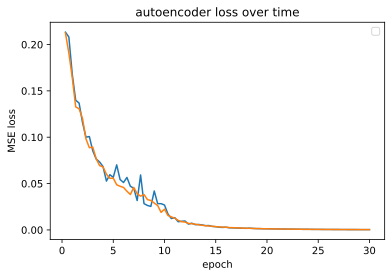

In [ ]:
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training loss')
ax.plot(losses['epoch'], losses['validation_loss'], label='Validation Loss')
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('autoencoder loss over time')
ax.legend()

In [ ]:
encoded = ae.get_encoded_representations()

In [ ]:
encoded

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.67272425, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.5496427 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
with open(path + 'ae_emb.pkl', 'wb') as fh:
    pickle.dump(encoded, fh)